In [40]:
#from __future__ import print_function
from pysph.solver.utils import load, iter_output, get_files
from matplotlib import pyplot as plt

In [62]:
files = get_files('Taylor_Green-PySPH_output')
t, corr, corr1 = [], [], []
for solver_data, array in iter_output(files, 'fluid'):
    t.append(solver_data['t'])
    c, _  = pearsonr(array.lmda, array.delta_p)
    corr.append(c)
    c, _  = pearsonr(array.lmda1, array.delta_p)
    corr.append(c)
    print(solver_data['t'])

0 [0.01166809 0.0328813  0.05000046 ... 0.95227256 0.97137368 0.99140247]
0.00045454545454545455 [0.01162874 0.0328472  0.04996624 ... 0.95229625 0.97139062 0.99142811]
0.0009090909090909091 [0.01158941 0.03281312 0.04993204 ... 0.95231993 0.97140756 0.99145375]
0.0013636363636363637 [0.0115501  0.03277906 0.04989785 ... 0.95234362 0.97142449 0.99147937]
0.0018181818181818182 [0.01151081 0.03274501 0.04986366 ... 0.95236731 0.97144142 0.99150498]
0.0022727272727272726 [0.01147153 0.03271097 0.04982948 ... 0.95239101 0.97145834 0.99153058]
0.002727272727272727 [0.01143228 0.03267693 0.0497953  ... 0.95241474 0.97147527 0.99155616]
0.0031818181818181815 [0.01139305 0.03264291 0.04976111 ... 0.95243849 0.97149221 0.99158174]
0.003636363636363636 [0.01135382 0.03260888 0.04972691 ... 0.95246228 0.97150915 0.9916073 ]
0.00409090909090909 [0.01131461 0.03257484 0.04969268 ... 0.95248612 0.97152612 0.99163285]
0.004545454545454545 [0.01127541 0.0325408  0.04965842 ... 0.95251001 0.97154311 0.

In [42]:
pa = data['arrays']['fluid']
type(pa) # This is the particle array.

pysph.base.particle_array.ParticleArray

In [44]:
from scipy.stats import pearsonr

In [57]:
corr, _  = pearsonr(pa.lmda, pa.delta_p)
corr

-0.1230877990452546

In [59]:
corr, _ = pearsonr(pa.lmda1, pa.delta_p)
corr

-0.13772623209807197

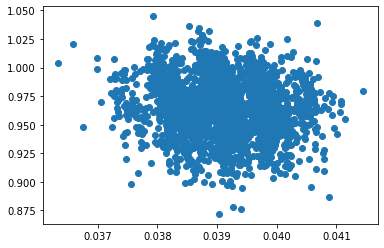

In [49]:
plt.scatter(pa.delta_p, pa.lmda)

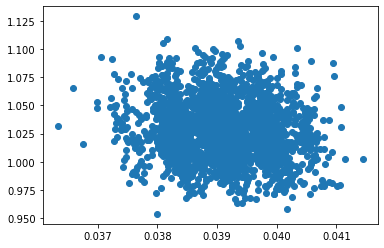

In [50]:
plt.scatter(pa.delta_p, pa.lmda1)

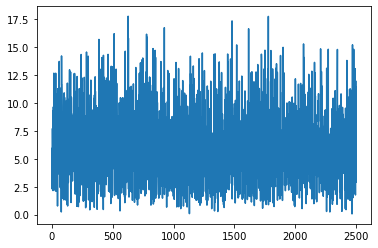

In [56]:
temp = 100.*np.abs(pa.lmda - pa.lmda1)/np.abs(pa.lmda1)
plt.plot(temp)